<a href="https://colab.research.google.com/github/annogass/ml-4/blob/main/Final_face_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio
!pip install wandb
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anigasitashvili","key":"31ff3d13351526141cdce5175f597602"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

100% 284M/285M [00:00<00:00, 476MB/s]
100% 285M/285M [00:00<00:00, 532MB/s]


In [6]:
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d data/

In [7]:
!ls data

example_submission.csv	fer2013.tar.gz	icml_face_data.csv  test.csv  train.csv


In [8]:
!pip install -q wandb

In [9]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: agasi22 (agasi22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
import pandas as pd
import numpy as np

In [11]:
train_df_t = pd.read_csv('/content/data/icml_face_data.csv')

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import wandb


In [13]:
train = train_df_t[train_df_t[' Usage'] == 'Training']
val = train_df_t[train_df_t[' Usage'] == 'PrivateTest']
test = train_df_t[train_df_t[' Usage'] == 'PublicTest']

In [14]:
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}




Sample training images:


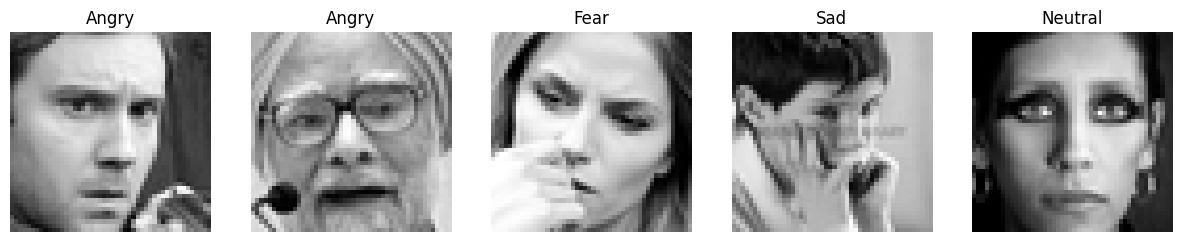

In [15]:
import matplotlib.pyplot as plt

def plot_sample_images(df, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        sample = df.iloc[i]
        pixels = np.array(sample[' pixels'].split(), dtype='uint8')
        img = pixels.reshape(48, 48)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(emotion_labels[sample['emotion']])
        axes[i].axis('off')
    plt.show()

print("\nSample training images:")
plot_sample_images(train)

In [16]:
class FERDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pixels = self.df.iloc[idx][' pixels']
        pixels = np.array(pixels.split(), dtype='uint8').reshape(48, 48)
        image = Image.fromarray(pixels)

        if self.transform:
            image = self.transform(image)

        label = self.df.iloc[idx]['emotion']
        return image, label


In [17]:
from PIL import Image
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [18]:
train_dataset = FERDataset(train, transform=transform_train)
val_dataset = FERDataset(val, transform=transform_val)
test_dataset = FERDataset(test, transform=transform_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import wandb

class FinalFaceCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(FinalFaceCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.skip = nn.Sequential(
            nn.Conv2d(64, 512, kernel_size=1, stride=8),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes))

    def forward(self, x):

        x1 = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.1)
        x = F.max_pool2d(x1, kernel_size=2, stride=2)

        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.1)
        x_skip = self.skip(x1)
        x = F.max_pool2d(x + x_skip, kernel_size=2, stride=2)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [20]:
wandb.init(project='fer-challenge', name='final-model')

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FinalFaceCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)


def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(data_loader), 100 * correct / total

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    best_val_acc = 0.0
    best_model_weights = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total


        val_loss, val_acc = evaluate_model(model, val_loader, criterion)


        scheduler.step(val_acc)


        if wandb.run is not None:
            wandb.log({
                'epoch': epoch,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'lr': optimizer.param_groups[0]['lr']
            })

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = model.state_dict()
            torch.save(best_model_weights, 'best_model.pth')
            print('Best model saved!')


    model.load_state_dict(best_model_weights)
    return model

trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)

Epoch [1/30], Train Loss: 1.6369, Train Acc: 34.80%, Val Loss: 1.4207, Val Acc: 45.08%, LR: 0.001000
Best model saved!
Epoch [2/30], Train Loss: 1.3457, Train Acc: 48.61%, Val Loss: 1.2606, Val Acc: 51.30%, LR: 0.001000
Best model saved!
Epoch [3/30], Train Loss: 1.2495, Train Acc: 52.62%, Val Loss: 1.2239, Val Acc: 53.05%, LR: 0.001000
Best model saved!
Epoch [4/30], Train Loss: 1.1897, Train Acc: 54.89%, Val Loss: 1.2655, Val Acc: 49.76%, LR: 0.001000
Epoch [5/30], Train Loss: 1.1435, Train Acc: 56.62%, Val Loss: 1.2168, Val Acc: 52.88%, LR: 0.001000
Epoch [6/30], Train Loss: 1.1042, Train Acc: 58.25%, Val Loss: 1.1188, Val Acc: 56.84%, LR: 0.001000
Best model saved!
Epoch [7/30], Train Loss: 1.0731, Train Acc: 59.40%, Val Loss: 1.0975, Val Acc: 57.90%, LR: 0.001000
Best model saved!
Epoch [8/30], Train Loss: 1.0403, Train Acc: 60.62%, Val Loss: 1.1153, Val Acc: 57.93%, LR: 0.001000
Best model saved!
Epoch [9/30], Train Loss: 1.0132, Train Acc: 61.93%, Val Loss: 1.1699, Val Acc: 54.6

In [23]:
print("\nEvaluating on test set...")
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')



Evaluating on test set...
Test Loss: 1.1044, Test Accuracy: 65.25%


In [24]:
wandb.log({'test_loss': test_loss, 'test_acc': test_acc})


Test set confusion matrix:


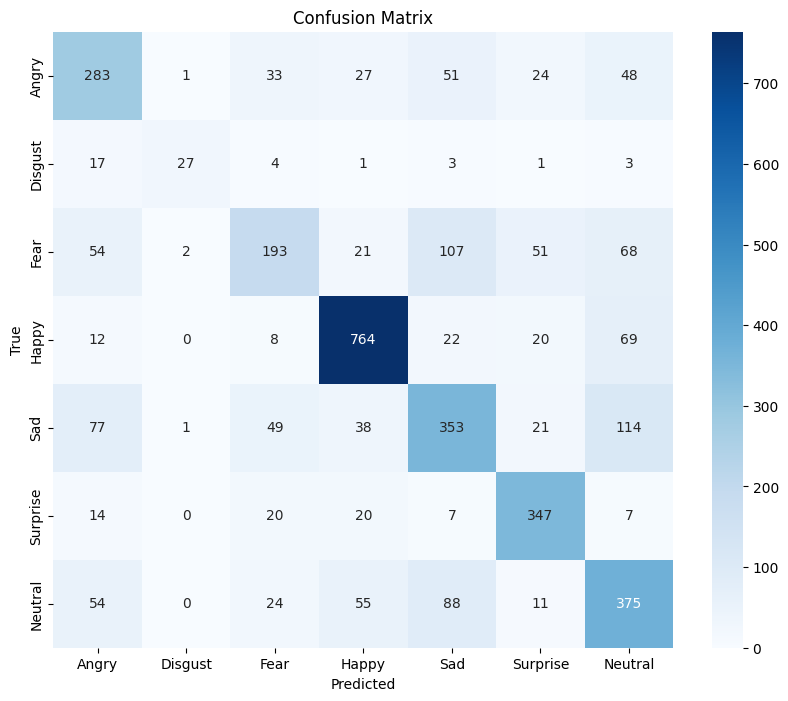


Classification Report:
              precision    recall  f1-score   support

       Angry       0.55      0.61      0.58       467
     Disgust       0.87      0.48      0.62        56
        Fear       0.58      0.39      0.47       496
       Happy       0.83      0.85      0.84       895
         Sad       0.56      0.54      0.55       653
    Surprise       0.73      0.84      0.78       415
     Neutral       0.55      0.62      0.58       607

    accuracy                           0.65      3589
   macro avg       0.67      0.62      0.63      3589
weighted avg       0.65      0.65      0.65      3589



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels.values(),
                yticklabels=emotion_labels.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    return cm, all_labels, all_preds

print("\nTest set confusion matrix:")
cm, all_labels, all_preds = plot_confusion_matrix(model, test_loader)

# Now we can use all_labels and all_preds for the classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=emotion_labels.values()))


In [26]:
torch.save(model.state_dict(), 'final_model.pth')
wandb.save('final_model.pth')

['/content/wandb/run-20250608_095230-z2jsudtv/files/final_model.pth']

In [27]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
train_loss,█▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▃▄▃▄▅▅▅▄▄▆▇▇▆▇▇▆▆▇▇▆▇▆▇█▇█▇▇▆
val_loss,█▅▅▅▅▃▂▃▄▄▂▁▁▂▁▁▃▃▁▂▃▂▄▂▂▂▁▃▅▇
epoch,29
lr,0.001
test_acc,65.25495
